In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
# %tensorflow_version only exists in Colab.
%tensorflow_version 2.x

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing

import os
import pathlib
import numpy as np
import pandas as pd
import IPython.display as display
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

from PIL import Image


print("Num GPUs Available: ", 
      len(tf.config.experimental.list_physical_devices('GPU')))
print("Tensorflow version: ", tf.__version__) 

Num GPUs Available:  1
Tensorflow version:  2.1.0


#Dataset Import and Overview

In [105]:
np.random.seed(101)
tf.random.set_seed(101)


LABELS_FILE = "/content/drive/My Drive/dogs/train_labels.csv"

df = pd.read_csv(LABELS_FILE)
print(df.head())

CLASS_NAMES = np.unique(df.breed)
BREED_COUNT = 63
class_count = len(CLASS_NAMES)

data_dir = "/content/drive/My Drive/dogs/Dataset/train"
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("Number of images:", image_count)

                                 id               breed
0  a32893132f6fbb3635df77c157c7d8e0  scottish_deerhound
1  3b3ae8c92f704bf449ea4bc61866461b  scottish_deerhound
2  c9bbc4ce586c0d73e14bee1b1e674ba9  scottish_deerhound
3  f194e48d99e5e0f279eb8cd5e6872e36  scottish_deerhound
4  03dc61595ad9dbf49e3998cf586ca8cb  scottish_deerhound
Number of images: 2205


#Image Loading

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count * 0.7 / BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [107]:
# get a dataset of all files matching the pattern
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())

b'/content/drive/My Drive/dogs/Dataset/train/norwegian_elkhound/d9483ad58c5e1ae2e73ac0de09aac90d.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/border_terrier/5501faf6694477c31ea97dede096154c.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/lhasa/4b3f4c910479686b10d676f813da0b3f.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/beagle/58154ab6841198957a50526106c72d72.jpg'
b'/content/drive/My Drive/dogs/Dataset/train/pembroke/4792cc9e614c5aa380ce532a2b182e16.jpg'


In [0]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    ## rescale the input channels to a range of [-1,1]
    #img = tf.cast(img, tf.float32)
    #img = (img / 127.5) - 1

    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label  

In [109]:
# apply process_path function to each element of this dataset, and return a new
# dataset containing the transformed elements, in the same order as they 
# appeared in the input.
# set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_ds.take(1):
    #print("Image tensor: ", image)
    #print("Label tensor:", label)
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label)
    l = []
    for j in range(1,3):
        l.append(label)
    print(l)

Image shape:  (224, 224, 3)
Label:  tf.Tensor(
[False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False], shape=(35,), dtype=bool)
[<tf.Tensor: shape=(35,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])>, <tf.Tensor: shape=(35,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])>]


# Data Preparation

In [0]:
def breed_distr(ds):
    for breed in CLASS_NAMES:
        count = 0
        for element in ds.as_numpy_iterator(): 
            label = CLASS_NAMES[element[1] == 1][0]
            if (breed in label):
                count += 1
        print(breed, count)


def split_ds(ds, ds_size, split, cache=True, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
  
    val_size = np.floor(ds_size * split)
    val_ds = ds.take(val_size)
    train_ds = ds.skip(val_size)
    
    return (train_ds, val_ds)


def prepare_for_training(ds, cache=True):
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    # Repeat forever
    ds = ds.repeat()
  
    ds = ds.batch(BATCH_SIZE)
  
    # `prefetch` lets the dataset fetch batches in the background while the 
    # model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
  
    return ds


def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15, 15))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n] == 1][0].title())
        plt.axis('off')

In [0]:
train_ds, val_ds = split_ds(labeled_ds, image_count, 0.3,
                                        cache="./dogs.tfcache")

In [0]:
#breed_distr(train_ds)
#breed_distr(val_ds)

##Data Augmentation

In [0]:
def process_image(image):
    image = tf.image.flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.5, upper=2)
    image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
    image = tf.image.random_crop(image, image.shape)

    return image, 

def tf_augment(image, label):
    img_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.float32])
    image.set_shape(img_shape)
    return image, label

In [0]:
augsrc_ds = train_ds
augmented_ds = augsrc_ds.repeat(2).map(tf_augment, num_parallel_calls=AUTOTUNE)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


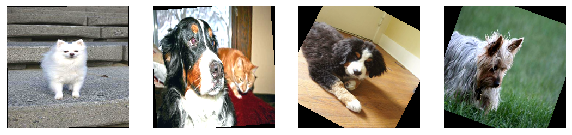

In [115]:
plt.figure(figsize=(10, 10))
i = 1
for image, label in augmented_ds.take(4):
    ax = plt.subplot(1, 4, i)
    plt.imshow(image)
    plt.axis('off')
    i = i + 1

In [116]:
batched_train_ds = prepare_for_training(augmented_ds).cache('./dogs-train.tfcache')
#batched_train_ds = prepare_for_training(train_ds).cache('./dogs-train.tfcache')
batched_val_ds = val_ds.batch(BATCH_SIZE).cache('./dogs-val.tfcache')


print(batched_train_ds)
print(batched_val_ds)
print(batched_train_ds.element_spec)
print(batched_val_ds.element_spec)

<CacheDataset shapes: ((None, 224, 224, 3), (None, 35)), types: (tf.float32, tf.bool)>
<CacheDataset shapes: ((None, 224, 224, 3), (None, 35)), types: (tf.float32, tf.bool)>
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 35), dtype=tf.bool, name=None))
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 35), dtype=tf.bool, name=None))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

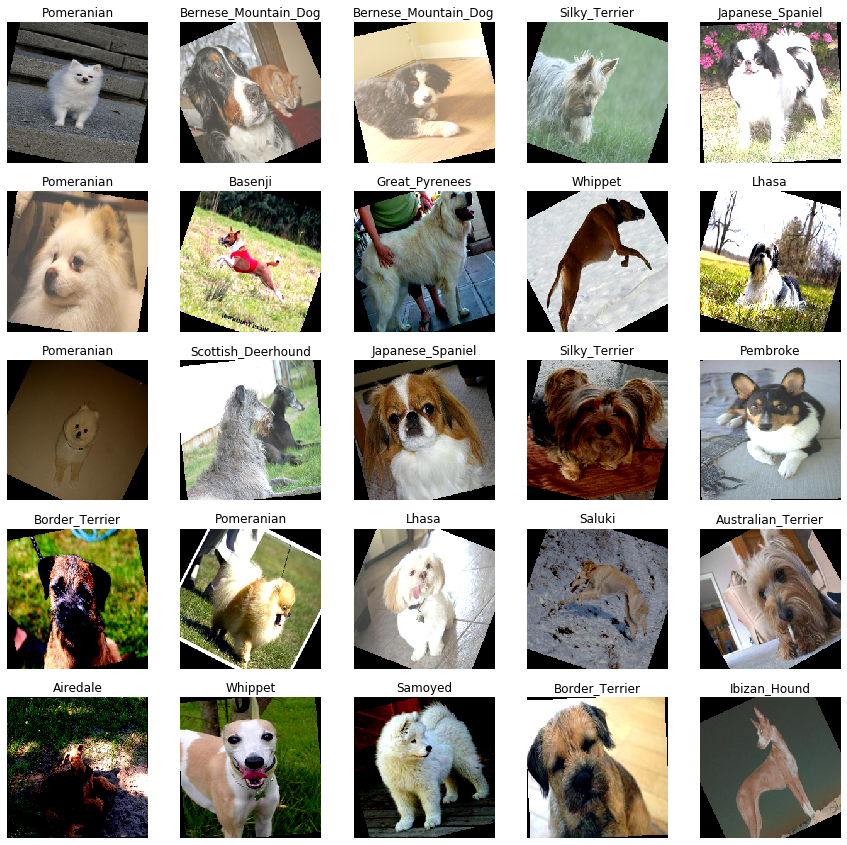

In [117]:
image_batch, label_batch = next(batched_train_ds.as_numpy_iterator())
#image_batch, label_batch = next(batched_val_ds.as_numpy_iterator())

show_batch(image_batch, label_batch)

In [0]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i%10 == 0:
            print('.', end='')
    print()
    end = time.time()
  
    duration = end-start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(BATCH_SIZE * steps / duration))

In [0]:
#timeit(batched_train_ds)

# Model

## Base Model

In [0]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [121]:
# Freeze the convolutional base (all the layers)
# prevents the weights in a given layer from being updated during training
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

## Classification Head

In [0]:
l2_penalty = 0.001
dropout_rate = 0.05

#head = models.Sequential()
#head.add(layers.Conv2D(32, (3, 3), activation='relu', 
#                        input_shape=IMG_SHAPE))
#head.add(layers.MaxPooling2D((2, 2)))
#head.add(layers.Dropout(dropout_rate))
#head.add(layers.Conv2D(64, (3, 3), activation='relu'))
#head.add(layers.MaxPooling2D((2, 2)))
#head.add(layers.Dropout(dropout_rate))
#head.add(layers.Conv2D(64, (3, 3), activation='relu'))
#head.add(layers.Flatten())
#head.add(layers.Dense(64, activation='relu',
#                       kernel_regularizer=regularizers.l2(l2_penalty)))
#head.add(layers.Dense(class_count, activation='softmax',
#                       kernel_regularizer=regularizers.l2(l2_penalty)))

global_average_layer = layers.GlobalAveragePooling2D()
dropout_layer = layers.Dropout(dropout_rate)
prediction_layer = layers.Dense(class_count, activation='softmax', 
                                kernel_regularizer=regularizers.l2(l2_penalty))

## Final Model

In [0]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dropout_layer,
    prediction_layer
])

### Feature Extraction

In [0]:
## hyperbolically decreasing learning rate over time
## It is computed as:
## def decayed_learning_rate(step):
##     return initial_learning_rate / (1 + decay_rate * step / decay_step) 
#lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#    initial_learning_rate=0.001,
#    decay_steps=STEPS_PER_EPOCH * 1000,
#    decay_rate=1,
#    staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [125]:
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=5)

history = model.fit(batched_train_ds, 
                    epochs=10,
                    verbose=1,
                    callbacks=[early_stopping],
                    validation_data=batched_val_ds,
                    steps_per_epoch=STEPS_PER_EPOCH
                    )

Train for 49.0 steps, validate for 21 steps
Epoch 1/10
49/49 [==============================] - 39s 802ms/step - loss: 2.8086 - accuracy: 0.2793 - val_loss: 1.4813 - val_accuracy: 0.6944
Epoch 2/10
49/49 [==============================] - 31s 628ms/step - loss: 1.4481 - accuracy: 0.6639 - val_loss: 0.9389 - val_accuracy: 0.7973
Epoch 3/10
49/49 [==============================] - 4s 82ms/step - loss: 0.9717 - accuracy: 0.7755 - val_loss: 0.7898 - val_accuracy: 0.8094
Epoch 4/10
49/49 [==============================] - 15s 299ms/step - loss: 0.8131 - accuracy: 0.8112 - val_loss: 0.7203 - val_accuracy: 0.8185
Epoch 5/10
49/49 [==============================] - 24s 500ms/step - loss: 0.6590 - accuracy: 0.8635 - val_loss: 0.6977 - val_accuracy: 0.8169
Epoch 6/10
49/49 [==============================] - 23s 464ms/step - loss: 0.5949 - accuracy: 0.8980 - val_loss: 0.6692 - val_accuracy: 0.8230
Epoch 7/10
49/49 [==============================] - 25s 510ms/step - loss: 0.5197 - accuracy: 0.9177

In [0]:
def show_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

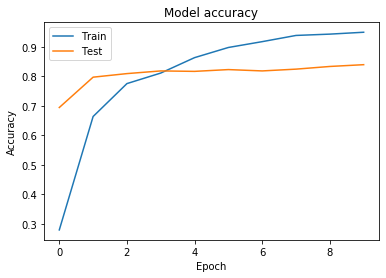

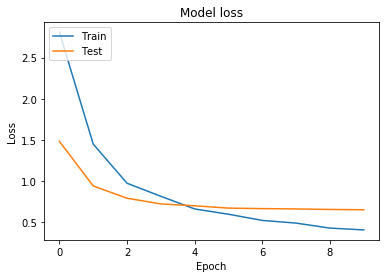

In [127]:
show_history(history)

### Fine Tuning

In [128]:
# Un-freeze the top layers of the model
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
num_base_layers = len(base_model.layers)
print("Number of layers in the base model: ", num_base_layers)

# Fine-tune from this layer onwards
fine_tune_at = int(np.ceil(num_base_layers * 2 / 3))
print(fine_tune_at)

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155
104


In [129]:
# compile the model reducing learning rate (default is 0.001)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
len(model.trainable_variables)

53

In [130]:
initial_epochs = 10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(batched_train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         verbose=1,
                         callbacks=[early_stopping],
                         validation_data=batched_val_ds,
                         steps_per_epoch=STEPS_PER_EPOCH)

Train for 49.0 steps, validate for 21 steps
Epoch 10/20
49/49 [==============================] - 19s 392ms/step - loss: 0.3442 - accuracy: 0.9547 - val_loss: 0.6580 - val_accuracy: 0.8306
Epoch 11/20
49/49 [==============================] - 24s 494ms/step - loss: 0.2686 - accuracy: 0.9707 - val_loss: 0.6336 - val_accuracy: 0.8517
Epoch 12/20
49/49 [==============================] - 22s 447ms/step - loss: 0.1616 - accuracy: 0.9981 - val_loss: 0.6734 - val_accuracy: 0.8351
Epoch 13/20
49/49 [==============================] - 25s 516ms/step - loss: 0.1564 - accuracy: 0.9994 - val_loss: 0.6636 - val_accuracy: 0.8457
Epoch 14/20
49/49 [==============================] - 24s 481ms/step - loss: 0.1300 - accuracy: 1.0000 - val_loss: 0.6457 - val_accuracy: 0.8457
Epoch 15/20
49/49 [==============================] - 23s 476ms/step - loss: 0.1284 - accuracy: 1.0000 - val_loss: 0.6303 - val_accuracy: 0.8487
Epoch 16/20
49/49 [==============================] - 23s 475ms/step - loss: 0.1256 - accurac

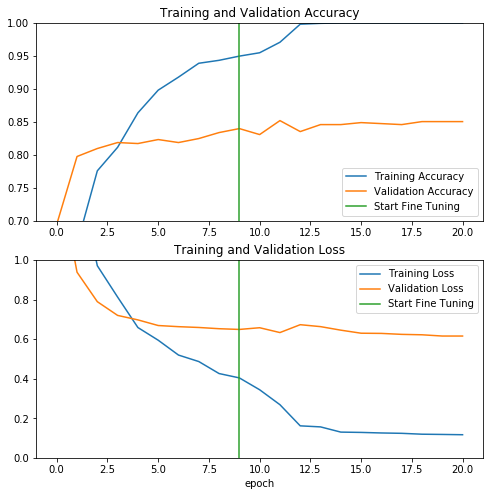

In [141]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Validation Overview

In [132]:
loss, accuracy = model.evaluate(batched_val_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

21/21 [==============================] - 1s 33ms/step - loss: 0.6160 - accuracy: 0.8502
Loss : 0.615964202653794
Accuracy : 0.85022694


In [133]:
predictions = model.predict(batched_val_ds)
print("Number of predictions:", len(predictions))
print(predictions[0])
print(np.argmax(predictions[0]))

Number of predictions: 661
[1.4477272e-02 8.5743864e-05 6.3007421e-05 1.2756143e-05 2.3082196e-06
 1.4384300e-03 5.5209035e-05 1.7940851e-05 3.0658132e-04 5.3155643e-04
 1.0477528e-05 4.3603379e-04 2.2044558e-06 1.1123305e-05 2.5309571e-06
 2.6756927e-04 2.4155734e-05 3.2180012e-04 6.5933575e-04 2.2578979e-04
 6.0120628e-06 8.9474094e-01 2.9475568e-06 6.8525755e-04 6.0596005e-07
 1.3582276e-05 7.2567263e-06 3.1288635e-06 2.1995275e-04 4.2686387e-04
 6.1806332e-04 9.9790277e-06 4.4201399e-05 8.4265158e-02 4.2096476e-06]
21


In [0]:
def plot_batch_image(i, predictions_array, image_batch, label_batch):

    predictions_array = predictions_array[i]
    true_label = np.where(label_batch[i] == True)[0][0]
    img = image_batch[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(image_batch[i])
  
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100 * np.max(predictions_array),
                                true_label),
                                color=color)
    plt.ylabel(CLASS_NAMES[label_batch[i] == True][0])


def plot_value_array(i, predictions_array, label_batch):
    predictions_array = predictions_array[i]
    true_label = np.where(label_batch[i] == True)[0][0]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(35), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

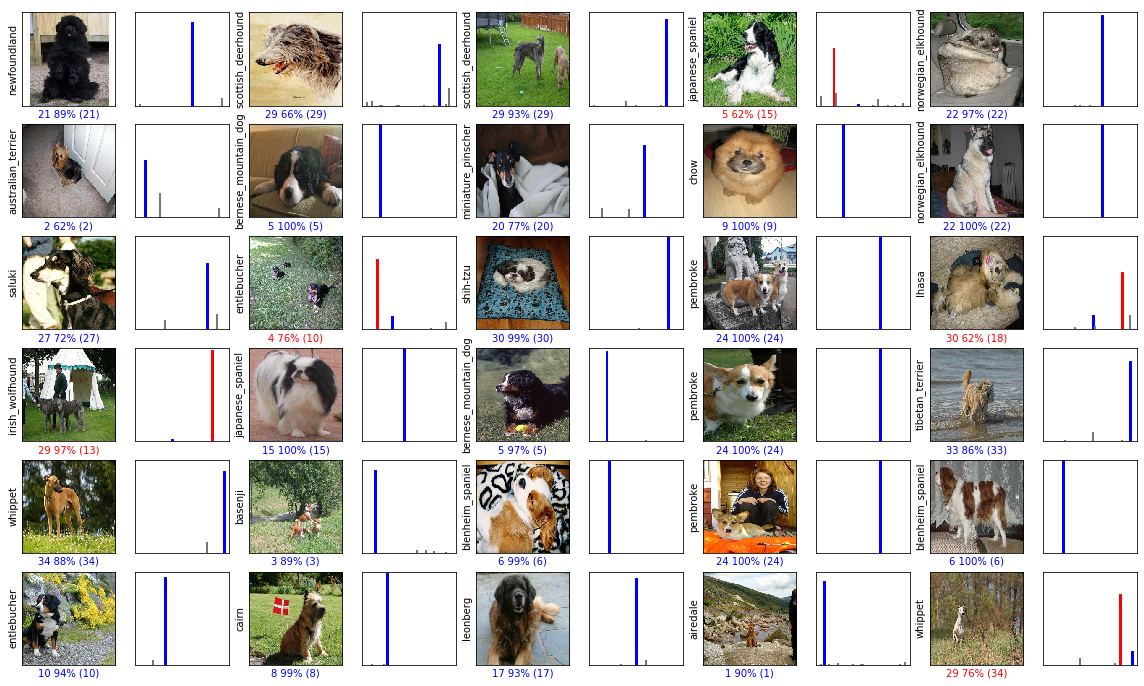

In [135]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 6
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
image_batch, label_batch = next(batched_val_ds.as_numpy_iterator())
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_batch_image(i, predictions, image_batch, label_batch)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions, label_batch)
plt.show()